In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import cmath
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7);

Populating the interactive namespace from numpy and matplotlib


In [2]:
countByDay = pd.read_csv('data\out_countByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
posByDay = pd.read_csv('data\out_posByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
neutrByDay = pd.read_csv('data\out_neutrByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')
negByDay = pd.read_csv('data\out_negByDay.csv', header=0, parse_dates=[0]).sort_values(by = 'day')

In [3]:
ftse = pd.read_csv('data\FTSE.csv', header=0, parse_dates=[0]).sort_values(by = 'Date')
ftse = ftse[['Date', 'Adj Close', 'Volume']]
ftse.columns = ['day', 'price', 'volume']

In [4]:
ftse['complex'] = ftse['price'] + ftse['volume'] * 1j
ftse.head()

,day,price,volume,complex
0,2015-02-11,6818.200195,623275800,(6818.200195+623275800j)
1,2015-02-12,6828.100098,809863300,(6828.100098+809863300j)
2,2015-02-13,6873.500000,734854200,(6873.5+734854200j)
3,2015-02-16,6857.100098,415979100,(6857.100098+415979100j)
4,2015-02-17,6898.100098,612932700,(6898.100098+612932700j)


In [5]:
results = pd.merge(posByDay, neutrByDay, on='day')
results = pd.merge(results, negByDay, on='day')
results.columns = ['day', 'positive', 'neutral', 'negative']
results.head()

,day,positive,neutral,negative
0,2016-02-24,738,4624,2511
1,2016-02-25,1138,6670,3583
2,2016-02-26,952,5775,3287
3,2016-02-27,804,4578,2360
4,2016-02-28,1057,5172,2616


In [6]:
results["diff"] = (results["positive"] - results["negative"])/(results["positive"] + results["neutral"] + results["negative"])
results.head()

,day,positive,neutral,negative,diff
0,2016-02-24,738,4624,2511,-0.225200
1,2016-02-25,1138,6670,3583,-0.214643
2,2016-02-26,952,5775,3287,-0.233174
3,2016-02-27,804,4578,2360,-0.200982
4,2016-02-28,1057,5172,2616,-0.176258


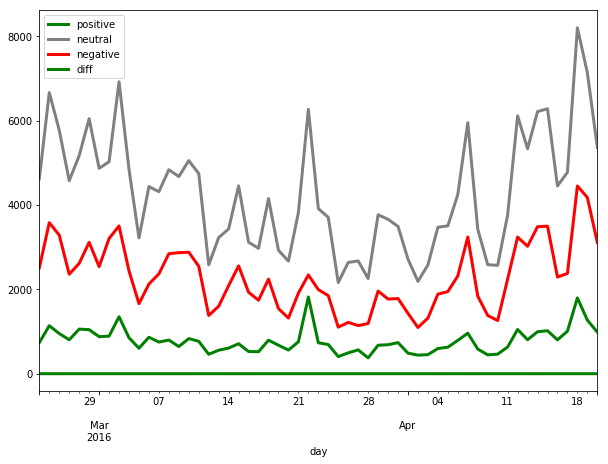

In [7]:
results.plot(x='day', linewidth = 3, color=['g', 'gray', 'r'])

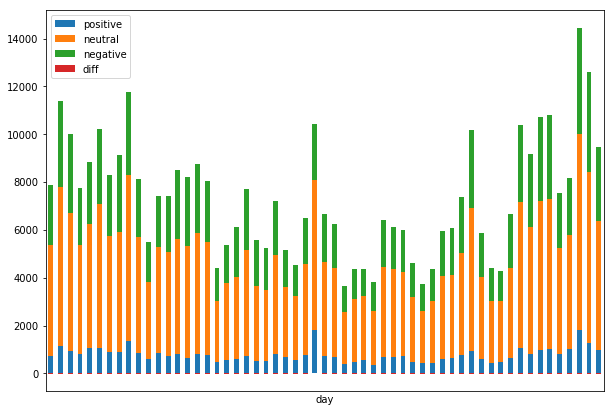

In [8]:
results.plot.bar(x='day', stacked=True);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [9]:
allRes = pd.merge(results[["day", "diff"]], ftse, on = 'day')
allRes.head()

,day,diff,price,volume,complex
0,2016-02-24,-0.225200,5867.200195,834682500,(5867.200195+834682500j)
1,2016-02-25,-0.214643,6012.799805,999956900,(6012.799805+999956900j)
2,2016-02-26,-0.233174,6096.000000,858937600,(6096+858937600j)
3,2016-02-29,-0.202879,6097.100098,941705500,(6097.100098+941705500j)
4,2016-03-01,-0.200386,6152.899902,933626200,(6152.899902+933626200j)


## Нахождение коэффициента парной корреляции 

In [10]:
def rc(x,y):
    rc_xy = (
        ((y.real + 1j*y.imag)*(x.real + 1j*x.imag)).sum()
        / 
        sqrt(((y.real + 1j*y.imag)**2).sum() * ((x.real + 1j*x.imag)**2).sum())
        )
    return rc_xy;

In [11]:
allRes.columns = ['date', 'sentimentCoef', 'price', 'volume', 'complex']
allRes = allRes.sort_values(by = 'date')
allRes.head()

,date,sentimentCoef,price,volume,complex
0,2016-02-24,-0.225200,5867.200195,834682500,(5867.200195+834682500j)
1,2016-02-25,-0.214643,6012.799805,999956900,(6012.799805+999956900j)
2,2016-02-26,-0.233174,6096.000000,858937600,(6096+858937600j)
3,2016-02-29,-0.202879,6097.100098,941705500,(6097.100098+941705500j)
4,2016-03-01,-0.200386,6152.899902,933626200,(6152.899902+933626200j)


In [12]:
print('rc volume-volume:      ' + str(rc(allRes['volume'],
                                    allRes['volume'])))

print('rc volume-price:       ' + str(rc(allRes['volume'],
                                    allRes['price'])))

print('rc price-volume*1000:  ' + str(rc(allRes['price'],
                                    allRes['volume']*1000)))

rc volume-volume:      (1+0j)
rc volume-price:       (0.983698611687+0j)
rc price-volume*1000:  (0.983698611687+0j)


In [13]:
#Стандартная функция для нахождения корреляции
np.corrcoef(allRes['volume'], allRes['price'])[0][1]

-0.16719534079322415

In [14]:
startShift = -10
endShift = 10
rcdf = pd.DataFrame(columns=('shift', 'rc'))

for i in range(startShift, endShift+1):
    if (i < 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['sentimentCoef'].iloc[:-i],
                                  allRes['price'].shift(i).iloc[:-i])]})
    elif (i == 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['sentimentCoef'],
                                  allRes['price'])]})
    else:    
        row = pd.DataFrame({"shift":[i], 
                        "rc": [rc(allRes['sentimentCoef'].iloc[i:],
                                  allRes['price'].shift(i).iloc[i:])]})

    rcdf = rcdf.append(row, ignore_index=True)
    
rcdf

,rc,shift
0,(-0.995260315057+0j),-10
1,(-0.995088887848+0j),-9
2,(-0.995159709049+0j),-8
3,(-0.99500395659+0j),-7
4,(-0.996163009856+0j),-6
5,(-0.998403800697+0j),-5
6,(-0.998450383206+0j),-4
7,(-0.999395860812+0j),-3
8,(-0.999709918624+0j),-2
9,(-1+0j),-1


## Нормирование результатов

In [15]:
allRes["sentimentCoefNorm"] = (allRes["sentimentCoef"] - allRes["sentimentCoef"].min()) / (allRes["sentimentCoef"].max() - allRes["sentimentCoef"].min())
allRes["priceNorm"] = (allRes["price"] - allRes["price"].min()) / (allRes["price"].max() - allRes["price"].min())
allRes["volumeNorm"] = (allRes["volume"] - allRes["volume"].min()) / (allRes["volume"].max() - allRes["volume"].min())

In [16]:
#Стандартная функция для нахождения корреляции
np.corrcoef(allRes['volumeNorm'], allRes['priceNorm'])[0][1]

-0.16719534079322421

In [17]:
print('rc volumeNorm-priceNorm: ' + str(rc(allRes['volumeNorm'],
                                           allRes['priceNorm'])))

rc volumeNorm-priceNorm: (0.804225225487+0j)


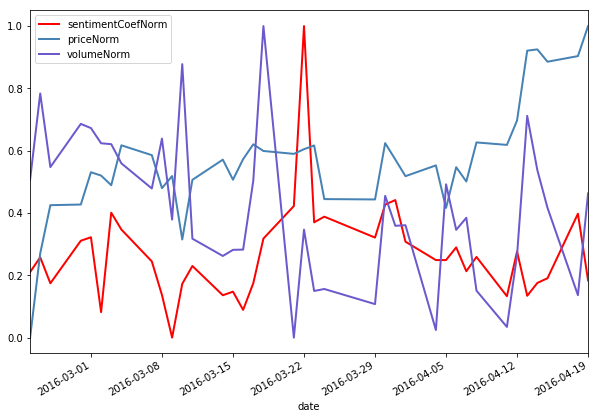

In [18]:
allRes[['date', 'sentimentCoefNorm', 'priceNorm', 'volumeNorm']].plot(x='date', linewidth = 2, color = ['r', 'steelblue', 'slateblue'])